C:\TempFolder\ipykernel_13864\2099270941.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')


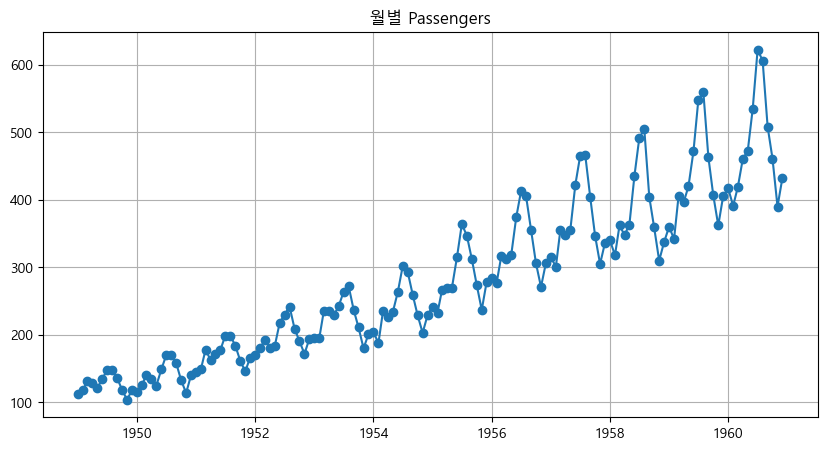

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Critical Values 1%: -3.4816817173418295
Critical Values 5%: -2.8840418343195267
Critical Values 10%: -2.578770059171598


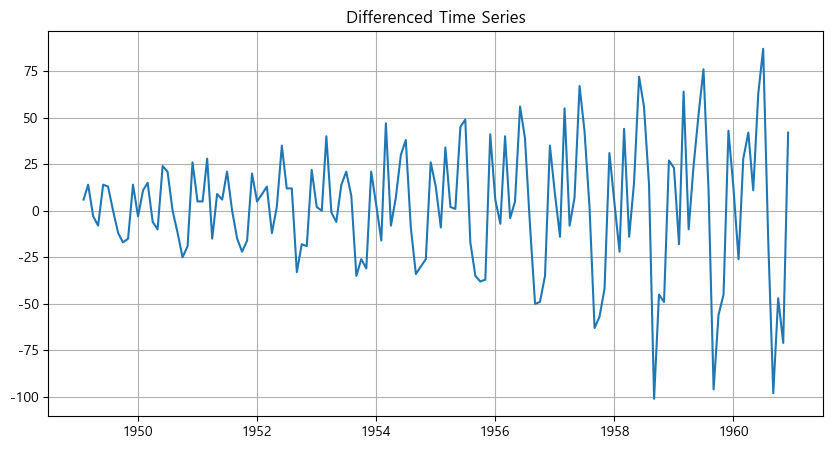

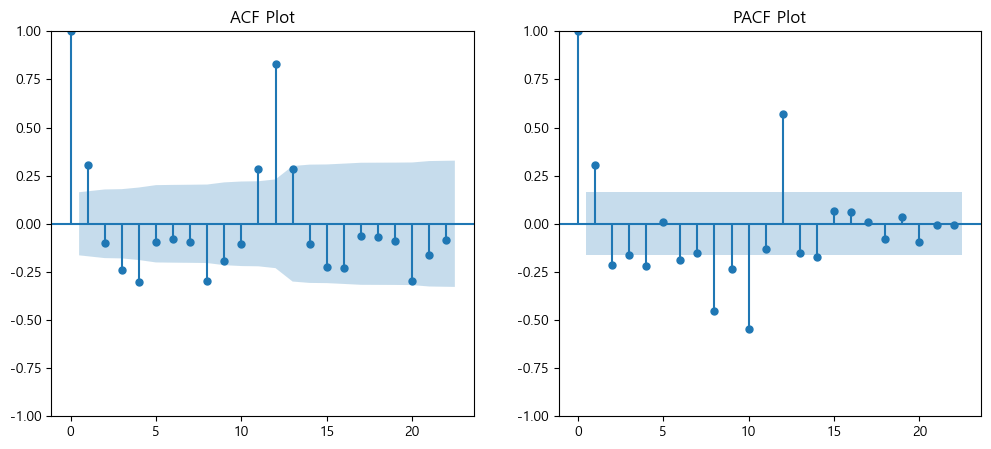

c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -503.124
Date:                            Mon, 12 May 2025   AIC                           1022.248
Time:                                    14:17:12   BIC                           1045.250
Sample:                                01-01-1949   HQIC                          1031.595
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0011   7.81e+04   1.47e-08      1.000   -1.53e+05    1.53e+05
is_winter  -8.911e-05   7.53e+04  -

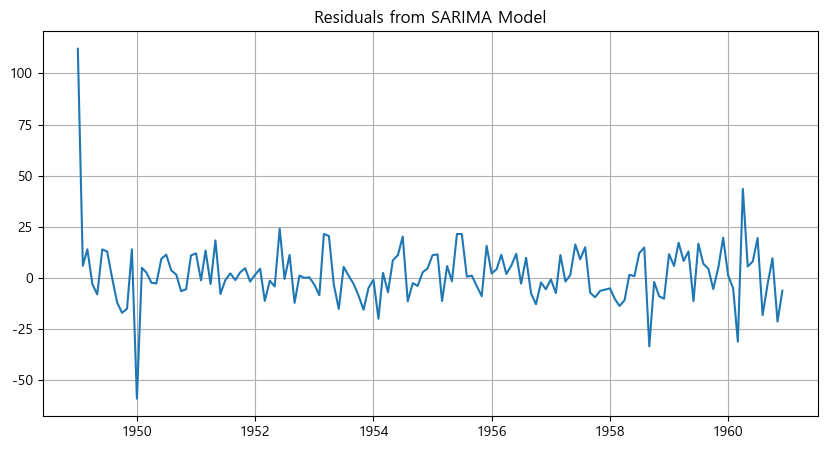

Forecasted Values:
1961-01-01    448.148541
1961-02-01    423.944784
1961-03-01    458.773847
1961-04-01    497.684928
1961-05-01    510.022482
1961-06-01    569.147564
1961-07-01    656.810093
1961-08-01    642.505058
1961-09-01    547.656233
1961-10-01    498.200902
1961-11-01    429.347937
1961-12-01    473.020198
Freq: MS, Name: predicted_mean, dtype: float64


C:\TempFolder\ipykernel_13864\2099270941.py:98: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', linestyle='--')


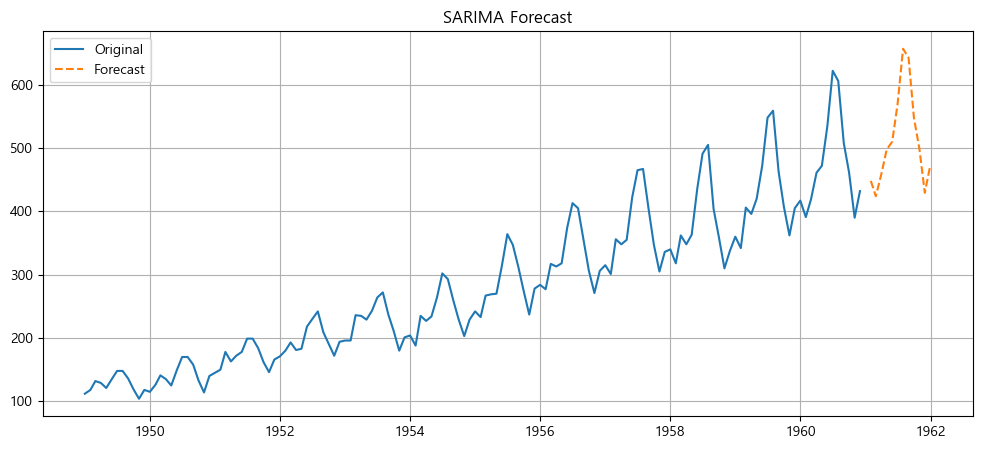

Mean Squared Error (MSE): 1360.5750912931985
Root Mean Squared Error (RMSE): 36.88597418115995


In [3]:
# SARIMA 테스트
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

# 2. 데이터 로딩 (AirPassengers 데이터셋 사용)
data = pd.read_csv('AirPassengers.csv')  # 파일명 맞게 확인
data.columns = ['Month', 'Passengers']  # 컬럼 이름을 기존 코드와 맞춤
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True)

# 외생 변수 선언
data['time'] = range(len(data)) # 12년 / 144개월의 len(data) = 144
data['is_winter'] = data.index.month.isin([12, 1, 2]).astype(int) # datatimeindex.month를 통해서 항상 1~12 사이 값만 반환

# 예측용 future exog 생성 (time: 144~155, is_winter 계산) // 데이터값을 안넣어줬기 떄문에 입력 해줌
future_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')
future_time = range(len(data), len(data) + 12)
future_is_winter = [int(month in [12, 1, 2]) for month in future_index.month]

exog_future = pd.DataFrame({
    'time': future_time,
    'is_winter': future_is_winter
}, index=future_index)

y = data['Passengers'] # 타겟 변수 Passengers
X = data[['time', 'is_winter']] # time, is_winter 을 exog로 넣어서 왜생변수로 사용

df = pd.DataFrame(data)

# 3. 시계열 데이터 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Passengers'], marker='o')
plt.title('월별 Passengers')
plt.grid()
plt.show()

# 4. 정상성 확인
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Values {key}: {value}')

# 5. 1차 차분
df['Passengers_diff'] = df['Passengers'].diff()

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Passengers_diff'])
plt.title('Differenced Time Series')
plt.grid()
plt.show()

# 6. ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Passengers_diff'].dropna(), ax=axes[0])
axes[0].set_title('ACF Plot')
plot_pacf(df['Passengers_diff'].dropna(), ax=axes[1])
axes[1].set_title('PACF Plot')
plt.show()

# 7. SARIMA 모델 학습
model = SARIMAX(
    endog=y,
    exog=X,
    order=(2,1,1),
    seasonal_order=(1,1,1,12)
    )
model_fit = model.fit()
print(model_fit.summary())

# 8. 잔차 분석
print('========================')
residuals = model_fit.resid
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)
print('========================')

plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals from SARIMA Model')
plt.grid()
plt.show()

# 9. 예측 및 시각화
forecast = model_fit.forecast(steps=12, exog = exog_future)
print("Forecasted Values:")
print(forecast)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Passengers'], label='Original')
plt.plot(pd.date_range(start=df.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', linestyle='--')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid()
plt.show()

# 10. 평가
# 실제 마지막 12개월과 비교 (주의: 정확한 비교는 아님)
if len(df['Passengers']) >= 24:
    mse = mean_squared_error(df['Passengers'][-12:], forecast)
    rmse = np.sqrt(mse)
    print('==================================================')
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print('==================================================')
else:
    print("실제값이 12개월 이상 존재하지 않아서 MSE 계산 생략됨.")


In [2]:
# matplotlib 한글 폰트 깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False